## Image Classification using Pytorch

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam


# Visualization tools
import torchvision
import torchvision.transforms.v2 as transform
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [ ]:
#Loading data into Memory, use Torchvision library which provide modules containing datasets
# We use valid_dataset, aiming to use fine_tuning to train

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
valid_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True)


In [4]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [5]:
valid_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [6]:
x_0, y_0 = train_dataset[0]

In [7]:
print(type(x_0), type(y_0))

<class 'PIL.Image.Image'> <class 'int'>


In [8]:
x_0

In [9]:
y_0

5

In [10]:
#transform them to tensor format, Torchvision is useful function to convert PIL Images to tensor
trans = transform.Compose([transform.ToTensor()])
x_0_tensor = trans(x_0)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [11]:
x_0_tensor.dtype

torch.float32

In [12]:
#PIL Images has a value from 0 to 255, when we convert tensor using ToTensor, the value is converted to 0 to 1
print(x_0_tensor.min(), x_0_tensor.max())

tensor(0.) tensor(1.)


In [13]:
# to see the size, Pytorch use C (color) x H (height) x W (width)
x_0_tensor.size()

torch.Size([1, 28, 28])

In [14]:
# By default a tensor is processed with a CPU to move a GPU, use .cuda
print(x_0_tensor.device)
x_0_tensor_gpu = x_0_tensor.cuda()
print(x_0_tensor_gpu.device)

cpu
cuda:0


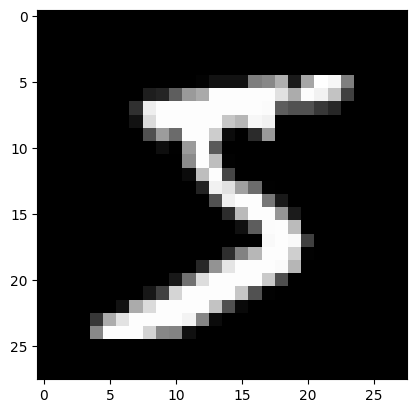

In [15]:
# from tensor to image we can use to_pil_image
image = F.to_pil_image(x_0_tensor)
plt.imshow(image, cmap='gray')

In [16]:
#  transform to a dataset

batch_size = 32

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=trans)
valid_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=trans)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False) # we use batch_size in the validation data to prevent memory errors

In [17]:
# Creating model
# 1-Step, Flatten: convert n-dimensional data into a vector
# 2-Step, Input layer
# 3-Step, Hidden layer
# 4-Stepm Output layer

input_size = 1 * 28 * 28
n_classes = 10

layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU(),  # Activation for hidden
    nn.Linear(512, n_classes)  # Output
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=10, bias=True)]

In [18]:
# Compiling the Method
model = nn.Sequential(*layers)   #as layers are a list we need to convert it to a squence using * operator
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

In [19]:
# when the model is first initialized, it will be processed  on a CPU. To have it process with a GPU

model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

In [20]:
# check which device
next(model.parameters()).device

device(type='cuda', index=0)

In [21]:
# Training Model
# loss and optimization: Loss function will grade students, use CrossEntropy
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [22]:
train_N = len(train_loader.dataset)
valid_N = len(valid_loader.dataset)

In [23]:
def get_batch_accuracy(output, y, N): # Calculate the accuracy of each batch
  pred = output.argmax(dim=1, keepdim=True)
  correct = pred.eq(y.view_as(pred)).sum().item()
  accuracy = correct / N
  return accuracy

In [24]:
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [25]:
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [26]:
epochs = 5

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 380.1665 Accuracy: 0.9379
Valid - Loss: 30.6875 Accuracy: 0.9698
Epoch: 1
Train - Loss: 164.3573 Accuracy: 0.9721
Valid - Loss: 27.9169 Accuracy: 0.9719
Epoch: 2
Train - Loss: 110.9502 Accuracy: 0.9811
Valid - Loss: 28.2778 Accuracy: 0.9728
Epoch: 3
Train - Loss: 81.0129 Accuracy: 0.9858
Valid - Loss: 23.9737 Accuracy: 0.9777
Epoch: 4
Train - Loss: 66.6415 Accuracy: 0.9891
Valid - Loss: 30.5697 Accuracy: 0.9747


In [29]:
x_1, y_1 = train_dataset[1]

In [30]:
trans = transform.Compose([transform.ToTensor()])
x_1_tensor = trans(x_1)

x_1_gpu = x_1_tensor.cuda()
prediction = model(x_1_gpu)
prediction

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


tensor([[ 17.0759, -19.6186,  -3.0234,  -8.8527,  -8.7486, -14.1048,  -1.8755,
          -9.9642, -15.8566, -10.7873]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [31]:
prediction.argmax(dim=1, keepdim=True) #using argmax we can find the index of the highest value

tensor([[0]], device='cuda:0')

In [32]:
y_1

0

## We now have a model that can be used to accurately detect and classify hand-written images.